# 

# An Introduction to JAX

This notebook (adapted Quantecon) provides a short introduction to
[Google JAX](https://github.com/google/jax).

## JAX as a NumPy Replacement

One way to use JAX is as a plug-in NumPy replacement. Let’s look at the
similarities and differences.

### Similarities

The following import is standard, replacing `import numpy as np`:

In [1]:
import jax
import jax.numpy as jnp

Now we can use `jnp` in place of `np` for the usual array operations:

In [3]:
a = jnp.array((1.0, 3.2, -1.5))

In [5]:
a

Array([ 1. ,  3.2, -1.5], dtype=float32)

In [6]:
print(jnp.sum(a))

2.7

In [7]:
print(jnp.mean(a))

0.90000004

In [8]:
print(jnp.dot(a, a))

13.490001

However, the array object `a` is not a NumPy array:

In [ ]:
a

In [9]:
type(a)

jaxlib.xla_extension.ArrayImpl

Even scalar-valued maps on arrays return JAX arrays.

In [10]:
jnp.sum(a)

Array(2.7, dtype=float32)

JAX arrays are also called “device arrays,” where term “device” refers
to a hardware accelerator (GPU or TPU).

(In the terminology of GPUs, the “host” is the machine that launches GPU
operations, while the “device” is the GPU itself.)

Operations on higher dimensional arrays are also similar to NumPy:

In [13]:
A = jnp.ones((2, 2))
B = jnp.identity(2)
A @ B

Array([[1., 1.],
       [1., 1.]], dtype=float32)

In [11]:
from jax.numpy import linalg

In [14]:
linalg.inv(B)   # Inverse of identity is identity

Array([[1., 0.],
       [0., 1.]], dtype=float32)

In [15]:
linalg.eigh(B)  # Computes eigenvalues and eigenvectors

EighResult(eigenvalues=Array([1., 1.], dtype=float32), eigenvectors=Array([[1., 0.],
       [0., 1.]], dtype=float32))

### Differences

One difference between NumPy and JAX is that JAX currently uses 32 bit
floats by default.

This is standard for GPU computing and can lead to significant speed
gains with small loss of precision.

However, for some calculations precision matters. In these cases 64 bit
floats can be enforced via the command

In [18]:
jax.config.update("jax_enable_x64", False)

Let’s check this works:

In [19]:
jnp.ones(3)

Array([1., 1., 1.], dtype=float32)

As a NumPy replacement, a more significant difference is that arrays are
treated as **immutable**.

For example, with NumPy we can write

In [24]:
import numpy as np
a = np.linspace(0, 1, 3)
a

array([0. , 0.5, 1. ])

and then mutate the data in memory:

In [25]:
a[0] = 1
a

array([1. , 0.5, 1. ])

In JAX this fails:

In [26]:
a = jnp.linspace(0, 1, 3)
a

Array([0. , 0.5, 1. ], dtype=float32)

In [ ]:
# a[0] = 1

In line with immutability, JAX does not support inplace operations:

In [28]:
a = np.array((2, 1))
a.sort()
a

array([1, 2])

In [29]:
a = jnp.array((2, 1))
a_new = a.sort()
a, a_new

(Array([2, 1], dtype=int32), Array([1, 2], dtype=int32))

The designers of JAX chose to make arrays immutable because JAX uses a
functional programming style. More on this below.

Note that, while mutation is discouraged, it is in fact possible with
`at`, as in

In [ ]:
a = jnp.linspace(0, 1, 3)
id(a)

In [ ]:
a

In [ ]:
a.at[0].set(1)

We can check that the array is mutated by verifying its identity is
unchanged:

In [ ]:
id(a)

## Random Numbers

Random numbers are also a bit different in JAX, relative to NumPy.
Typically, in JAX, the state of the random number generator needs to be
controlled explicitly.

In [30]:
import jax.random as random

First we produce a key, which seeds the random number generator.

In [33]:
key = random.PRNGKey(890)

In [34]:
key

Array([  0, 890], dtype=uint32)

In [ ]:
type(key)

In [ ]:
print(key)

Now we can use the key to generate some random numbers:

In [37]:
random.normal(key)

Array(-2.0482526, dtype=float32)

In [38]:
x = random.normal(key, (3, 3))
x

Array([[ 0.19565429,  0.8483543 ,  2.5626206 ],
       [ 1.2186607 , -0.05403523, -1.1299851 ],
       [-0.5350078 , -0.52225316,  2.3058493 ]], dtype=float32)

If we use the same key again, we initialize at the same seed, so the
random numbers are the same:

In [ ]:
random.normal(key, (3, 3))

To produce a (quasi-) independent draw, best practice is to “split” the
existing key:

In [39]:
key, subkey = random.split(key)

In [40]:
random.normal(key, (3, 3))

Array([[ 0.10447779,  0.27723557,  0.20472701],
       [ 0.8713728 ,  1.0725205 ,  1.2199067 ],
       [-0.76907164, -0.36064702,  0.56155264]], dtype=float32)

In [41]:
random.normal(subkey, (3, 3))

Array([[-1.2834829 ,  1.0401716 ,  0.5913942 ],
       [ 0.69168454, -0.31450266, -0.5352716 ],
       [ 1.3163713 ,  0.09488011,  1.4356968 ]], dtype=float32)

The function below produces `k` (quasi-) independent random `n x n`
matrices using this procedure.

In [ ]:
def gen_random_matrices(key, n, k):
    matrices = []
    for _ in range(k):
        key, subkey = random.split(key)
        matrices.append(random.uniform(subkey, (n, n)))
    return matrices

In [ ]:
matrices = gen_random_matrices(key, 2, 2)
for A in matrices:
    print(A)

One point to remember is that JAX expects tuples to describe array
shapes, even for flat arrays. Hence, to get a one-dimensional array of
normal random draws we use `(len, )` for the shape, as in

In [ ]:
random.normal(key, (5, ))

## JIT compilation

The JAX just-in-time (JIT) compiler accelerates logic within functions
by fusing linear algebra operations into a single optimized kernel that
the host can launch on the GPU / TPU (or CPU if no accelerator is
detected).

### A first example

To see the JIT compiler in action, consider the following function.

In [ ]:
def f(x):
    a = 3*x + jnp.sin(x) + jnp.cos(x**2) - jnp.cos(2*x) - x**2 * 0.4 * x**1.5
    return jnp.sum(a)

Let’s build an array to call the function on.

In [43]:
n = 50_000_000
x = jnp.ones(n)

How long does the function take to execute?

In [48]:
%%time
f(x).block_until_ready()

CPU times: user 3.61 s, sys: 2.64 s, total: 6.25 s
Wall time: 1.74 s

Array(2.1989598e+08, dtype=float32)

``` {note}
Here, in order to measure actual speed, we use the `block_until_ready()` method 
to hold the interpreter until the results of the computation are returned from
the device. This is necessary because JAX uses asynchronous dispatch, which
allows the Python interpreter to run ahead of GPU computations.
```

The code doesn’t run as fast as we might hope, given that it’s running
on a GPU.

But if we run it a second time it becomes much faster:

In [ ]:
%time f(x).block_until_ready()

This is because the built in functions like `jnp.cos` are JIT compiled
and the first run includes compile time.

Why would JAX want to JIT-compile built in functions like `jnp.cos`
instead of just providing pre-compiled versions, like NumPy?

The reason is that the JIT compiler can specialize on the *size* of the
array being used, which is helpful for parallelization.

For example, in running the code above, the JIT compiler produced a
version of `jnp.cos` that is specialized to floating point arrays of
size `n = 50_000_000`.

We can check this by calling `f` with a new array of different size.

In [ ]:
m = 50_000_001
y = jnp.ones(m)

In [ ]:
%time f(y).block_until_ready()

Notice that the execution time increases, because now new versions of
the built-ins like `jnp.cos` are being compiled, specialized to the new
array size.

If we run again, the code is dispatched to the correct compiled version
and we get faster execution.

In [ ]:
%time f(y).block_until_ready()

The compiled versions for the previous array size are still available in
memory too, and the following call is dispatched to the correct compiled
code.

In [ ]:
%time f(x).block_until_ready()

### Compiling the outer function

We can do even better if we manually JIT-compile the outer function.

In [49]:
f_jit = jax.jit(f)   # target for JIT compilation

Let’s run once to compile it:

In [50]:
f_jit(x)

Array(2.1989598e+08, dtype=float32)

And now let’s time it.

In [51]:
%time f_jit(x).block_until_ready()

CPU times: user 3.73 s, sys: 218 ms, total: 3.94 s
Wall time: 361 ms

Array(2.1989598e+08, dtype=float32)

Note the speed gain.

This is because the array operations are fused and no intermediate
arrays are created.

Incidentally, a more common syntax when targetting a function for the
JIT compiler is

In [ ]:
@jax.jit
def f(x):
    a = 3*x + jnp.sin(x) + jnp.cos(x**2) - jnp.cos(2*x) - x**2 * 0.4 * x**1.5
    return jnp.sum(a)

## Functional Programming

From JAX’s documentation:

*When walking about the countryside of Italy, the people will not
hesitate to tell you that JAX has “una anima di pura programmazione
funzionale”.*

In other words, JAX assumes a functional programming style.

The major implication is that JAX functions should be pure.

A pure function will always return the same result if invoked with the
same inputs.

In particular, a pure function has

-   no dependence on global variables and
-   no side effects

JAX will not usually throw errors when compiling impure functions but
execution becomes unpredictable.

Here’s an illustration of this fact, using global variables:

In [61]:
a = 1  # global

@jax.jit
def f(x):
    if len(x)<10:
        print("Something")
        return a + x
    else:
        x

In [62]:
x = jnp.ones(2)

In [63]:
f(x)

Something

Array([2., 2.], dtype=float32)

In the code above, the global value `a=1` is fused into the jitted
function.

Even if we change `a`, the output of `f` will not be affected — as long
as the same compiled version is called.

In [ ]:
a = 42

In [ ]:
f(x)

Changing the dimension of the input triggers a fresh compilation of the
function, at which time the change in the value of `a` takes effect:

In [ ]:
x = jnp.ones(3)

In [ ]:
f(x)

Moral of the story: write pure functions when using JAX!

## Gradients

JAX can use automatic differentiation to compute gradients.

This can be extremely useful for optimization and solving nonlinear
systems.

We will see significant applications later in this lecture series.

For now, here’s a very simple illustration involving the function

In [64]:
def f(x):
    return (x**2) / 2

Let’s take the derivative:

In [65]:
f_prime = jax.grad(f)

In [67]:
jax.grad(f_prime)(10.0)

Array(1., dtype=float32, weak_type=True)

Let’s plot the function and derivative, noting that $f'(x) = x$.

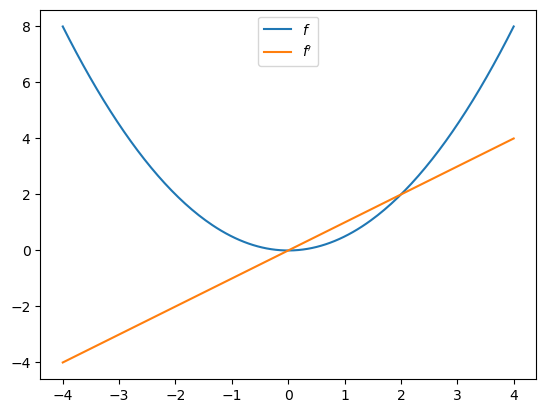

In [68]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
x_grid = jnp.linspace(-4, 4, 200)
ax.plot(x_grid, f(x_grid), label="$f$")
ax.plot(x_grid, [f_prime(x) for x in x_grid], label="$f'$")
ax.legend(loc='upper center')
plt.show()

We defer further exploration of automatic differentiation with JAX until
{doc}`autodiff`.

## Writing vectorized code

Writing fast JAX code requires shifting repetitive tasks from loops to
array processing operations, so that the JAX compiler can easily
understand the whole operation and generate more efficient machine code.

This procedure is called **vectorization** or **array programming**, and
will be familiar to anyone who has used NumPy or MATLAB.

In most ways, vectorization is the same in JAX as it is in NumPy.

But there are also some differences, which we highlight here.

As a running example, consider the function

$$
    f(x,y) = \frac{\cos(x^2 + y^2)}{1 + x^2 + y^2}
$$

Suppose that we want to evaluate this function on a square grid of $x$
and $y$ points and then plot it.

To clarify, here is the slow `for` loop version.

In [70]:
@jax.jit
def f(x, y):
    return jnp.cos(x**2 + y**2) / (1 + x**2 + y**2)

n = 80
x = jnp.linspace(-2, 2, n)
y = x

z_loops = np.empty((n, n))

In [71]:
%%time
for i in range(n):
    for j in range(n):
        z_loops[i, j] = f(x[i], y[j])

CPU times: user 1.65 s, sys: 5.43 ms, total: 1.66 s
Wall time: 1.66 s

Even for this very small grid, the run time is extremely slow.

(Notice that we used a NumPy array for `z_loops` because we wanted to
write to it.)

  

OK, so how can we do the same operation in vectorized form?

If you are new to vectorization, you might guess that we can simply
write

In [ ]:
z_bad = f(x, y)

In [76]:
%time f(x[:,jnp.newaxis], y[jnp.newaxis,:])

CPU times: user 3.34 ms, sys: 837 μs, total: 4.18 ms
Wall time: 3.11 ms

Array([[-0.01616667,  0.00612768,  0.02861433, ...,  0.02861422,
         0.00612757, -0.01616667],
       [ 0.00612768,  0.02920887,  0.05161642, ...,  0.05161631,
         0.02920875,  0.00612768],
       [ 0.02861433,  0.05161642,  0.07308776, ...,  0.07308766,
         0.05161631,  0.02861433],
       ...,
       [ 0.02861422,  0.05161631,  0.07308766, ...,  0.0730876 ,
         0.0516162 ,  0.02861422],
       [ 0.00612757,  0.02920875,  0.05161631, ...,  0.0516162 ,
         0.02920864,  0.00612757],
       [-0.01616667,  0.00612768,  0.02861433, ...,  0.02861422,
         0.00612757, -0.01616667]], dtype=float32)

But this gives us the wrong result because JAX doesn’t understand the
nested for loop.

In [ ]:
z_bad.shape

Here is what we actually wanted:

In [ ]:
z_loops.shape

To get the right shape and the correct nested for loop calculation, we
can use a `meshgrid` operation designed for this purpose:

In [ ]:
x_mesh, y_mesh = jnp.meshgrid(x, y)

Now we get what we want and the execution time is very fast.

In [ ]:
%%time
z_mesh = f(x_mesh, y_mesh).block_until_ready()

Let’s run again to eliminate compile time.

In [ ]:
%%time
z_mesh = f(x_mesh, y_mesh).block_until_ready()

Let’s confirm that we got the right answer.

In [ ]:
jnp.allclose(z_mesh, z_loops)

Now we can set up a serious grid and run the same calculation (on the
larger grid) in a short amount of time.

In [ ]:
n = 6000
x = jnp.linspace(-2, 2, n)
y = x
x_mesh, y_mesh = jnp.meshgrid(x, y)

In [ ]:
%%time
z_mesh = f(x_mesh, y_mesh).block_until_ready()

Let’s run again to get rid of compile time.

In [ ]:
%%time
z_mesh = f(x_mesh, y_mesh).block_until_ready()

But there is one problem here: the mesh grids use a lot of memory.

In [ ]:
x_mesh.nbytes + y_mesh.nbytes

By comparison, the flat array `x` is just

In [ ]:
x.nbytes  # and y is just a pointer to x

This extra memory usage can be a big problem in actual research
calculations.

So let’s try a different approach using
[jax.vmap](https://jax.readthedocs.io/en/latest/_autosummary/jax.vmap.html)

  

First we vectorize `f` in `y`.

In [73]:
f_vec_y = jax.vmap(f, in_axes=(None, 0))  

In the line above, `(None, 0)` indicates that we are vectorizing in the
second argument, which is `y`.

Next, we vectorize in the first argument, which is `x`.

In [74]:
f_vec = jax.vmap(f_vec_y, in_axes=(0, None))

With this construction, we can now call the function $f$ on flat (low
memory) arrays.

In [77]:
%%time
z_vmap = f_vec(x, y)

CPU times: user 2.42 ms, sys: 172 μs, total: 2.59 ms
Wall time: 2.2 ms

We run it again to eliminate compile time.

In [ ]:
%%time
z_vmap = f_vec(x, y).block_until_ready()

The execution time is essentially the same as the mesh operation but we
are using much less memory.

And we produce the correct answer:

In [ ]:
jnp.allclose(z_vmap, z_mesh)